# Classification

In the previous chapter we have learned about logistic regression, an ideal first example for classification algorithms given its proximity with standard regression. In this chapter we present a few additional algorithms, and like for regression, show that these methods can also be used with multiple variables.

## Multiple variables

First we check that logistic regression can be used with more than one variable. To demonstrate this, we use here again the movement dataset:

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

movement = pd.read_csv('../data/movement.csv')

Let's recap what we have seen before: the type of exercises (classified as 0 and 1) can be predicted based on the acceleration measured along one coordinate, here Z:

In [7]:
from sklearn import linear_model

X = movement[['z_acc']]
y = movement['move_type']

log_model = linear_model.LogisticRegression()
log_model.fit(X=X, y=y)

X_pred = pd.DataFrame(np.arange(-10, 50, 0.1), columns=['z_acc'])
pred_prob = log_model.predict_proba(X_pred)
pred = log_model.predict(X_pred)

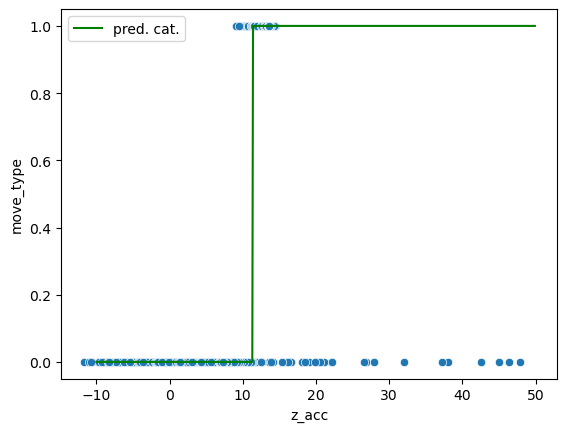

In [8]:
ax = sns.scatterplot(data=movement, x='z_acc', y='move_type');
ax.plot(np.arange(-10, 50, 0.1), pred, 'g', label='pred. cat.')
ax.legend();

However we see that the classification can never be perfect: there's no threshold that allows to perfectly classify the data. But what happens if we look at more than one feature. For example we can add the Y coordinate. Now we have two features and the third axis represents the class. We can show this in actual 3D or in 2D by coloring the two classes:

In [9]:
import matplotlib

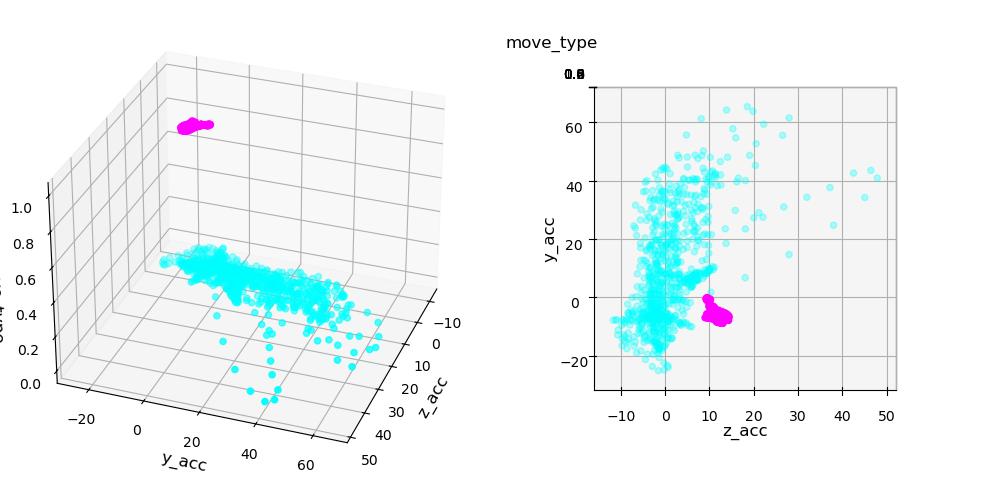

In [11]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
axes = [ax1, ax2]
for ax in axes:
    scatter = ax.scatter(movement['z_acc'].values,
                     movement['y_acc'].values,
                     movement['move_type'].values,
                     c=movement['move_type'].values, cmap='cool'
                        )
                        

    ax.set_xlabel('z_acc', fontdict={'fontsize':12})
    ax.set_ylabel('y_acc', fontdict={'fontsize':12});
    ax.set_zlabel('move_type', fontdict={'fontsize':12});

ax1.view_init(elev=30., azim=20)
ax2.view_init(elev=90., azim=-90)
ax2.set_proj_type('ortho')
fig.tight_layout()

We clearly see that while we can't set a perfect boundary on either feature, if we combined them we can draw a separation. This is exactly what can be achieved via logistic regression with multiple features. Let's define features and target and fit the model:

In [12]:
X = movement[['z_acc', 'y_acc']]
y = movement['move_type']

log_model = linear_model.LogisticRegression()
log_model.fit(X=X, y=y)

LogisticRegression()

We can again represent the separation by a a sigmoid, except that now we have a complete plane in the shape of a sigmoid:

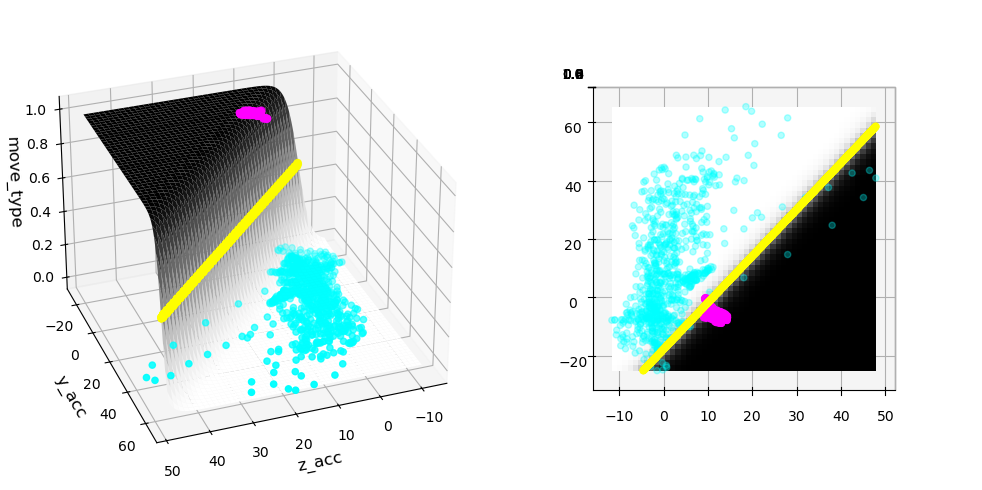

In [13]:
# create grid of points
X_1_grid, X_2_grid = np.meshgrid(
    np.linspace(movement['z_acc'].min(), movement['z_acc'].max(), 1000),
    np.linspace(movement['y_acc'].min(), movement['y_acc'].max(), 1000)
)

# do predictions
pred = log_model.predict(pd.DataFrame({'z_acc': X_1_grid.ravel(), 'y_acc': X_2_grid.ravel()}))
pred_prob = log_model.predict_proba(pd.DataFrame({'z_acc': X_1_grid.ravel(), 'y_acc': X_2_grid.ravel()}))

# select points around decision boundary
sel_line = pred_prob[:,1].copy()
sel_X_1 = X_1_grid.ravel()
sel_X_2 = X_2_grid.ravel()
sel_X_1 = sel_X_1[(sel_line<=0.51) & (sel_line>=0.49)]
sel_X_2 = sel_X_2[(sel_line<=0.51) & (sel_line>=0.49)]
sel_line = sel_line[(sel_line<=0.51) & (sel_line>=0.49)]+0


fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d', computed_zorder=False)
ax2 = fig.add_subplot(1, 2, 2, projection='3d', computed_zorder=False)

axes = [ax1, ax2]
for ax in axes:
    surf = ax.plot_surface(X_1_grid, X_2_grid, pred_prob[:,1].reshape(X_1_grid.shape),
                           cmap='Greys', antialiased=True, vmin=0, vmax=1)

    scatter = ax.scatter(movement['z_acc'].values,
                     movement['y_acc'].values,
                     movement['move_type'].values,
                     c=movement['move_type'].values, cmap='cool')
    
    scatter = ax.scatter(sel_X_1, sel_X_2, sel_line, c='Yellow')

    ax1.set_xlabel('z_acc', fontdict={'fontsize':12})
    ax1.set_ylabel('y_acc', fontdict={'fontsize':12});
    ax1.set_zlabel('move_type', fontdict={'fontsize':12});
ax1.view_init(elev=30., azim=70)
ax2.view_init(elev=90., azim=-90)
ax2.set_proj_type('ortho')
fig.tight_layout()

In the plot above we see that when looking at the surface sigmoid from the top, the boundary becomes just a line! We also see that the separation is now much better!

## Support Vector Machines

In the case of logistic regression, the optimization of the model is made based on a statistical model which is the "happiest" when data are far away from the boundary between classes. In the case of Support Vector Machines (SVC), we try to maximize the **margin** between two classes. In other words, as long as points are classified correctly we only care about points which are very close to the boundary and somehow define it.

Let's have a looks at the example above and try the SVM model which is found in the ```svm``` module:

In [14]:
from sklearn import svm

Here again, we define our ```X``` and ```y``` variable, create our model and call the ```fit``` function. The ```C``` parameter controls how much we are sensitive to outliers (see next section):


In [15]:
clf = svm.SVC(kernel="linear", C=1)
clf.fit(X, y);

As before we can find the category of a given point using the ```predict``` method. Additionally we can now recover information about how far a given point is form the separation "hyper-plane":

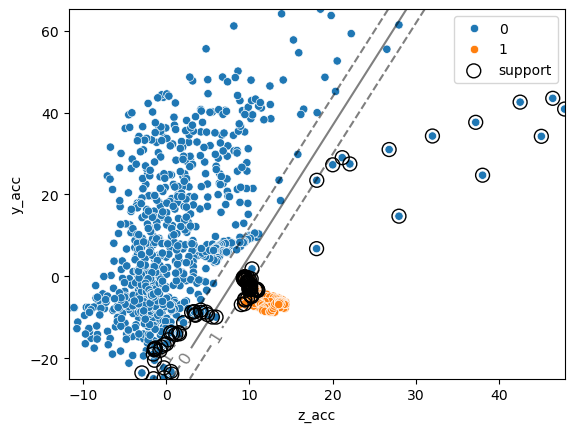

In [16]:
ax = sns.scatterplot(data=movement, x='z_acc', y='y_acc', hue='move_type')

xx = np.linspace(movement['z_acc'].min(), movement['y_acc'].max(), 1000)
yy = np.linspace(movement['z_acc'].min(), movement['y_acc'].max(),1000)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(pd.DataFrame(xy, columns=['z_acc', 'y_acc'])).reshape(XX.shape)

# plot decision boundary and margins
CS = ax.contour(
    X_1_grid, X_2_grid, Z, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');
ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

One of the main advantages of SVMs is that it's quite easy to define non-linear boundaries. We don't want to get into technical details here, but the general idea is similar to what we have seen in linear regression when we transformed the features into polynomial features. For SVMs, non-linearities are defined by choosing a **kernel**. For example we can consider again a polynomial kernel:

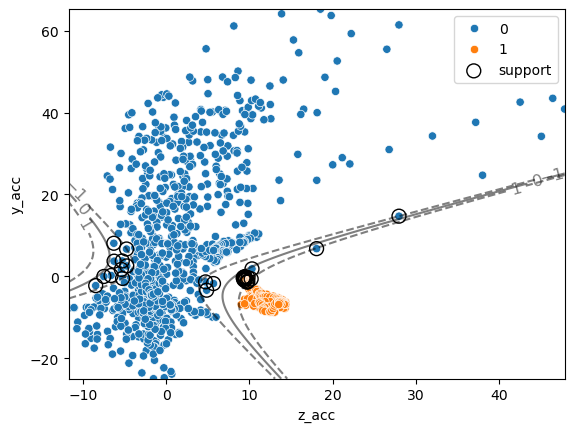

In [17]:
X = movement[['z_acc', 'y_acc']]
y = movement['move_type']

clf_nonlin = svm.SVC(kernel='poly', degree=2, C=10)
clf_nonlin.fit(X, y);

xx = np.linspace(movement['z_acc'].min(), movement['z_acc'].max(), 1000)
yy = np.linspace(movement['y_acc'].min(), movement['y_acc'].max(), 1000)
XX, YY = np.meshgrid(xx, yy)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

ax = sns.scatterplot(data=movement, x='z_acc', y='y_acc', hue='move_type')

Z_nonlin = clf_nonlin.decision_function(pd.DataFrame(xy, columns=['z_acc', 'y_acc'])).reshape(XX.shape)

# plot decision boundary and margins
CS = ax.contour(
    XX, YY, Z_nonlin, colors="k", levels=[-1, 0, 1], alpha=0.5,
    linestyles=["--", "-", "--"]
)

# plot support vectors
ax.scatter(clf_nonlin.support_vectors_[:, 0], clf_nonlin.support_vectors_[:, 1],
           s=100, linewidth=1, facecolors="none", edgecolors="k", label='support');

ax.clabel(CS, inline=1, fontsize=12)
ax.legend();

## Nearest neighbors

In scikit-learn you can find even more algorithms for classification. There are also multiple variations of implementations e.g. for SVMs which are beyond the purpose of this course. We briefly here mention the nearest neighbor algorithm.

As the name says, the idea is here to check for any point in the feature space, how many points of each category are neighbors. Using the algorithm works in the same way as always:

In [18]:
from sklearn import neighbors

In [19]:
kn_model = neighbors.KNeighborsClassifier()
kn_model.fit(X=X, y=y);

And the prediction is done exactly as above on an array of values:

/var/folders/mk/632_7fgs4v374qc935pvf9v00000gn/T/ipykernel_92924/1110588993.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=movement, x='z_acc', y='y_acc', style='move_type', s=100,


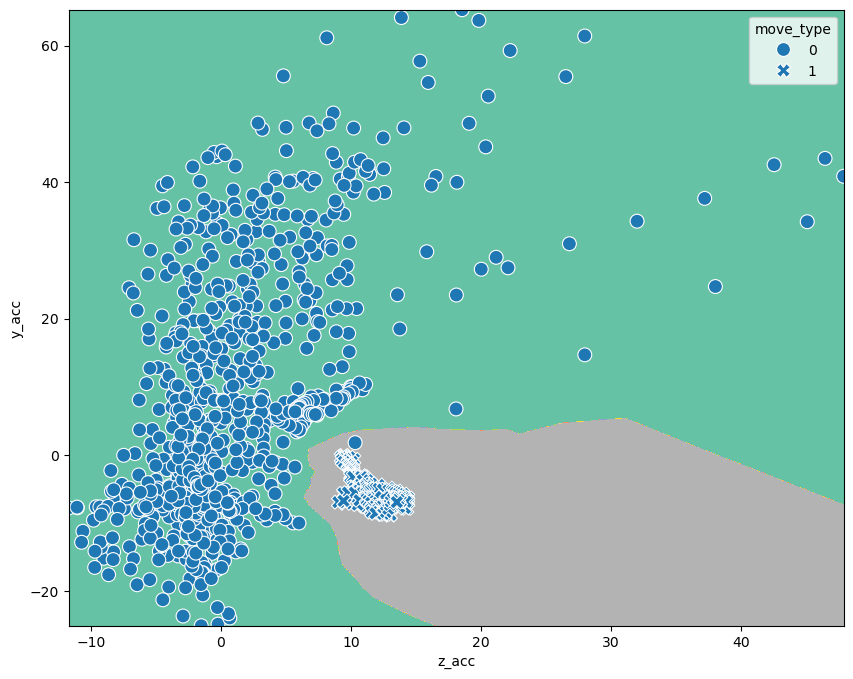

In [20]:
Z_kn = kn_model.predict(pd.DataFrame(xy, columns=['z_acc', 'y_acc'])).reshape(XX.shape)

fig, ax = plt.subplots(figsize=(10,8))

CS = ax.contourf(
    XX, YY, Z_kn, cmap='Set2'
)
sns.scatterplot(data=movement, x='z_acc', y='y_acc', style='move_type', s=100,
                ax=ax, palette='tab20');

We see that through this small number, outliers become more important. Depending on whether these outliers are meaningful (you might get such values again) or true outliers, this can be a positive or negative aspect.

## Exercises

We use here a dataset about properties of seeds. There are three types of seeds an measurements about their area, perimeter etc. 

1. Load a dataset about seed properties using:

In [21]:
seeds = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt',
                    sep='\t', on_bad_lines='skip', names=['area', 'perimeter', 'compactness', 'length', 'width', 'symmetry_coef', 'length_groove', 'seed_type']
)
seeds = seeds[(seeds.seed_type == 1) | (seeds.seed_type == 3)]


2. Perform classification via logistic regression to predict the ```seed_type``` using only ```length_groove``` and then ```length_groove``` and ```perimeter``` features. Measure the accuracy of the classification.

3. Perform classification via k-nearest neighbours